# Lab2. Pytorch Regression (Linear Regression vs MLP)  

Regression Problem을 `pytorch`로 해결 두가지 모델

*   Regression Problem을 `pytorch`로 해결 두가지 모델
*   (Linear Regression, MLP)을 둘 다 구현해보고 실제로 모델이 생각하는 데이터 분포를 시각화

*   MLP가 가지는 엄청난 non-linearity learning ability를 직접 살펴보기


### Install Pytorch (For Google Colab)

In [1]:
#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)


     |████████████████████████████████| 591.8 MB 635 bytes/s 
     |████████████████████████████████| 23.3 MB 1.5 MB/s 
     |████████████████████████████████| 23.3 MB 1.7 MB/s 
     |████████████████████████████████| 22.1 MB 11.7 MB/s 
     |████████████████████████████████| 22.1 MB 11.7 MB/s 
     |████████████████████████████████| 17.4 MB 234 kB/s 
     |████████████████████████████████| 17.3 MB 62 kB/s 
     |████████████████████████████████| 12.8 MB 20.9 MB/s 
     |████████████████████████████████| 12.7 MB 11.9 MB/s 
     |████████████████████████████████| 11.8 MB 25.6 MB/s 
     |████████████████████████████████| 5.9 MB 22.5 MB/s 
     |████████████████████████████████| 6.6 MB 38.5 MB/s 
     |████████████████████████████████| 6.6 MB 24.7 MB/s 
     |████████████████████████████████| 4.0 MB 18.8 MB/s 
     |████████████████████████████████| 10.2 MB 5.7 MB/s 
     |████████████████████████████████| 10.1 MB 34.6 MB/s 
     |████████████████████████████████| 8.8 MB 24.9 MB/s 
     

### 1. Data Generation  (Preparation)

*   Regression 실습에 사용할 데이터를 만들기
*    X가 2차원 Y가 1차원



$$ e \sim \mathcal{N} (0, 0.5) $$
$$y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  

*   데이터 분포는 아래와 같고, 관측시 발생한 오차 $e$가 더해져있다.
*   non-linear 함수 ($sin(x)$ 함수와 $log(x)$ 함수)

**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$


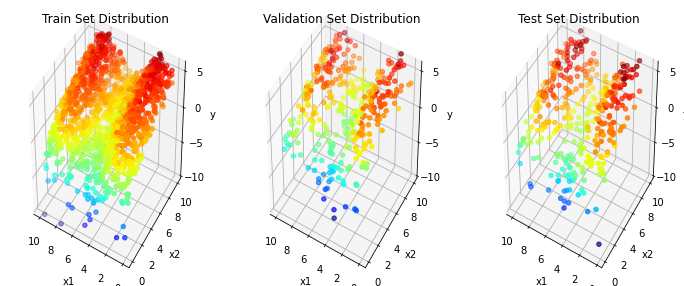

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#데이터셋만들기
num_data = 2400  #2400의 랜덤샘플
#2400의 랜덤샘플을 0~1의 uniform distribution에서 샘플링 
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e

#데이터를 Train, Valid, Test로 split
train_X, train_y = X[:1600, :], y[:1600]  #1600개
val_X, val_y = X[1600:2000, :], y[1600:2000]  #400개
test_X, test_y = X[2000:, :], y[2000:]  #400개

#3D 공간에 시각화
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

### 2. Hypothesis Define (Model Define)  
**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

In [3]:
#Linear Regression 시에 활용하는 H(x) = Wx + b를 
#파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어준다.
import torch
import torch.nn as nn

class LinearModel(nn.Module):   #선형모델
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True)  #x의차원=2/y의차원=1
    
    def forward(self, x):  #인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴
        return self.linear(x)
        
class MLPModel(nn.Module):  #mlp모델
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):#인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

### 3. Cost Function Define (Loss Function Define)  



In [4]:
#파이토치 nn 아래있는 다양한 loss functions
#MSE, Cross-Entropy, KL-Divergence..
#우리가 할 실습은 Regression Problem 이므로 MSE Loss 사용
reg_loss = nn.MSELoss()

"""uncomment for testing Loss Function
test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))
"""


'uncomment for testing Loss Function\ntest_pred_y = torch.Tensor([0,0,0,0])\ntest_true_y = torch.Tensor([0,1,0,1])\n\nprint(reg_loss(test_pred_y, test_true_y))\nprint(reg_loss(test_true_y, test_true_y))\n'

### 4. Train & Evaluation
이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다. 

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게됩니다. 
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다. 여기서 Metric으로는 mean absolute error(MAE)를 활용해보죵  

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

801 parameters


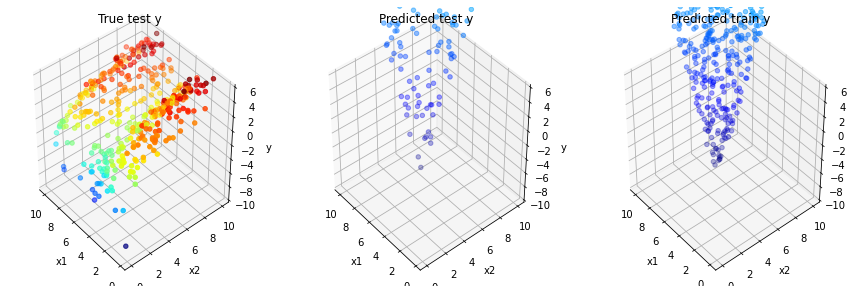

0 tensor(1031.9680, grad_fn=<MseLossBackward>)


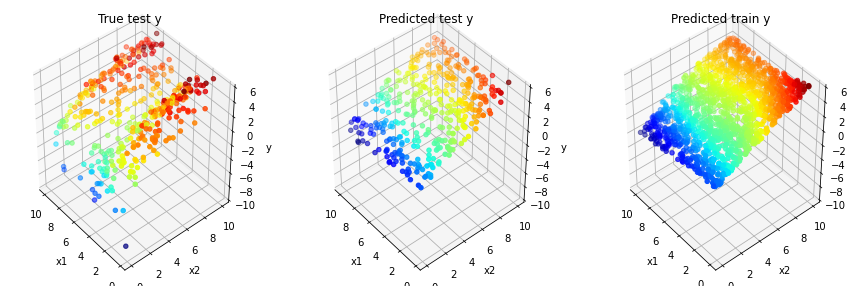

200 tensor(2.4257, grad_fn=<MseLossBackward>)


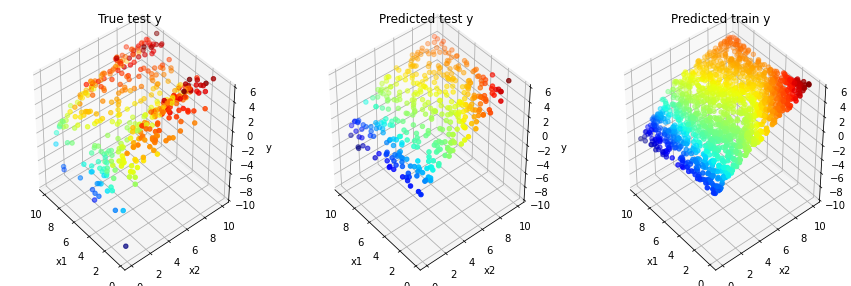

400 tensor(2.1996, grad_fn=<MseLossBackward>)


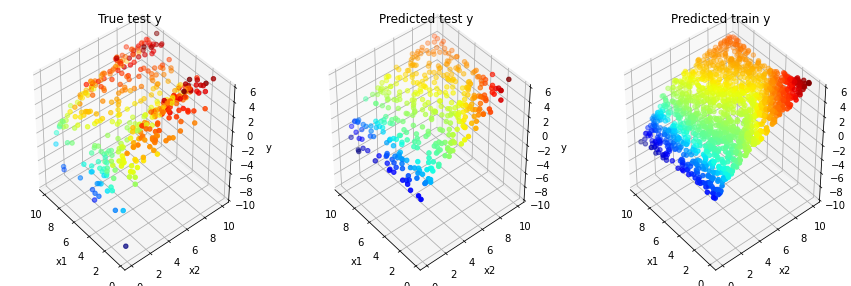

600 tensor(2.1150, grad_fn=<MseLossBackward>)


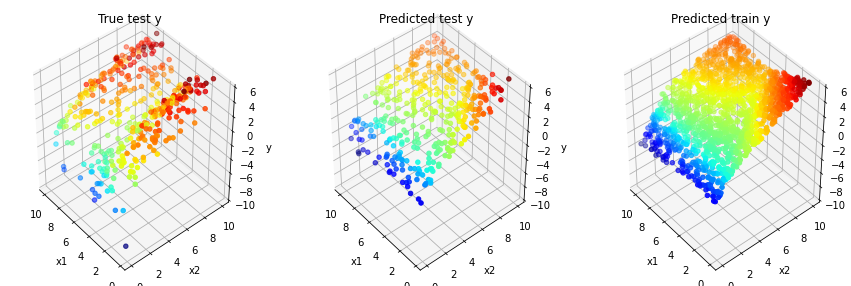

800 tensor(2.0634, grad_fn=<MseLossBackward>)


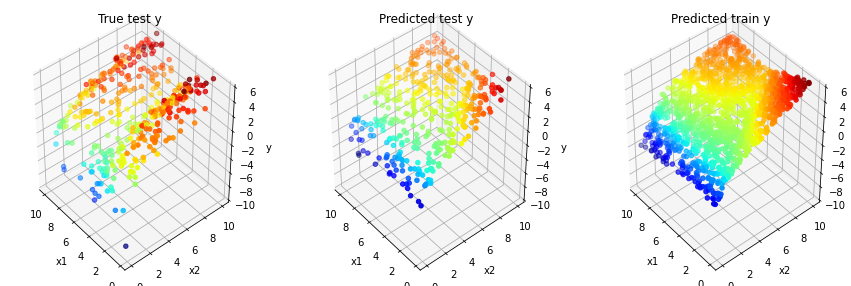

1000 tensor(2.0166, grad_fn=<MseLossBackward>)


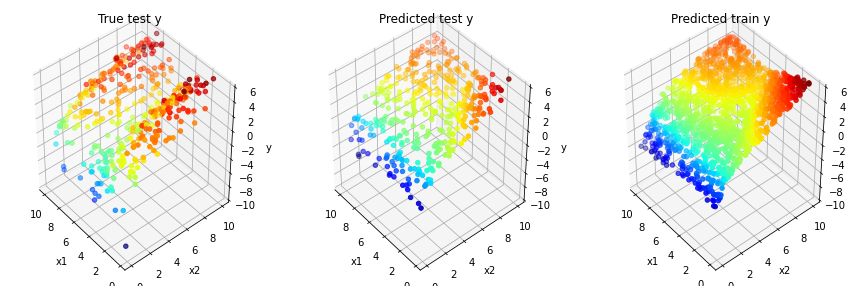

1200 tensor(1.9717, grad_fn=<MseLossBackward>)


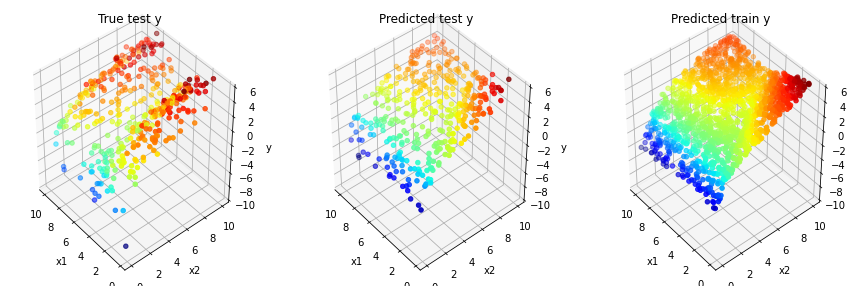

1400 tensor(1.9332, grad_fn=<MseLossBackward>)


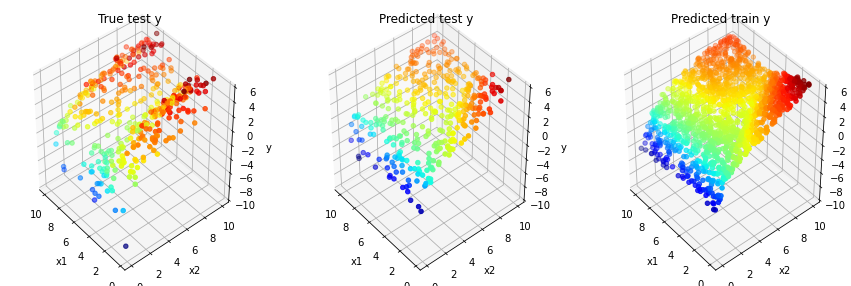

1600 tensor(1.8985, grad_fn=<MseLossBackward>)


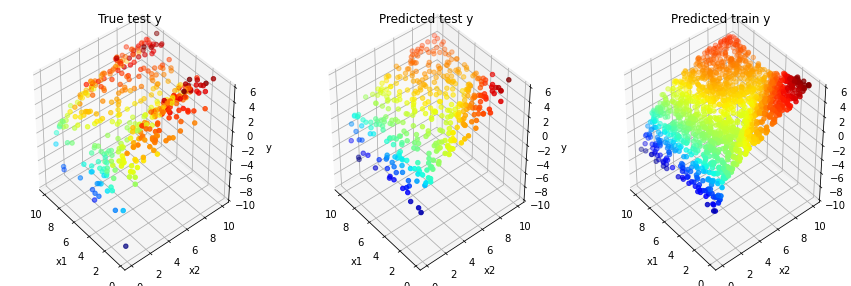

1800 tensor(1.8602, grad_fn=<MseLossBackward>)


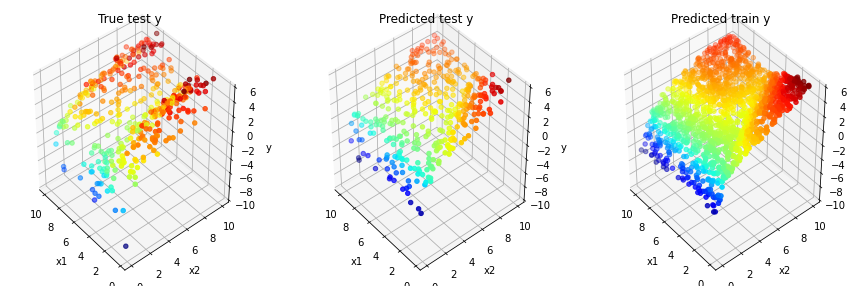

2000 tensor(1.8283, grad_fn=<MseLossBackward>)


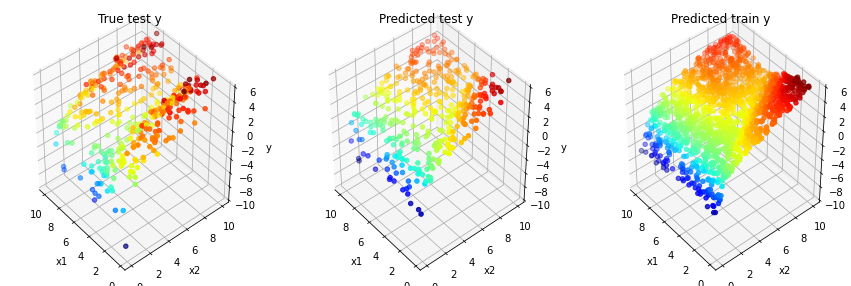

2200 tensor(1.7862, grad_fn=<MseLossBackward>)


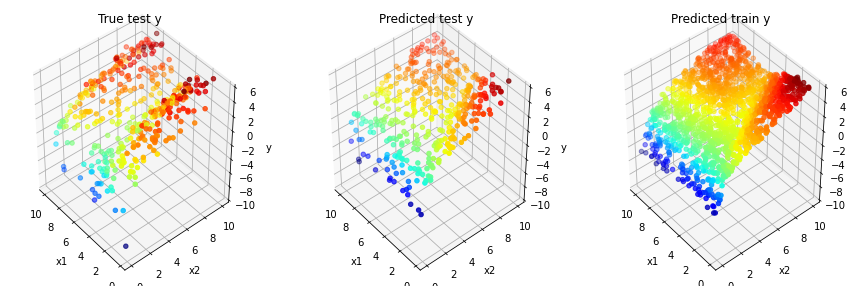

2400 tensor(1.7503, grad_fn=<MseLossBackward>)


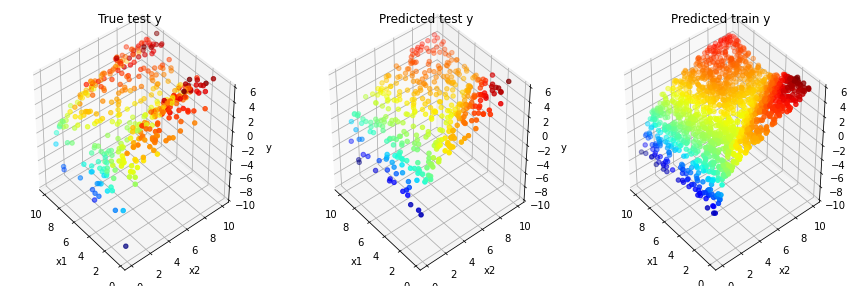

2600 tensor(1.7010, grad_fn=<MseLossBackward>)


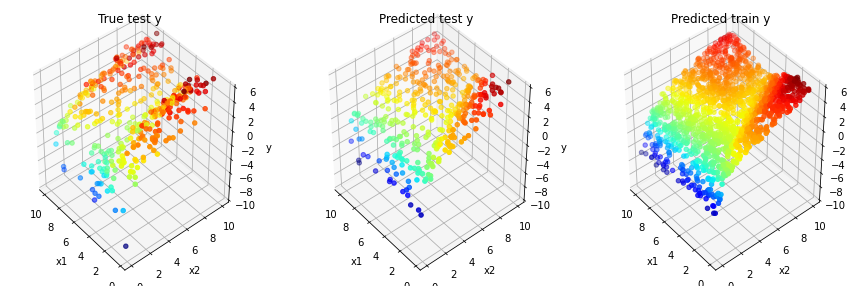

2800 tensor(1.6669, grad_fn=<MseLossBackward>)


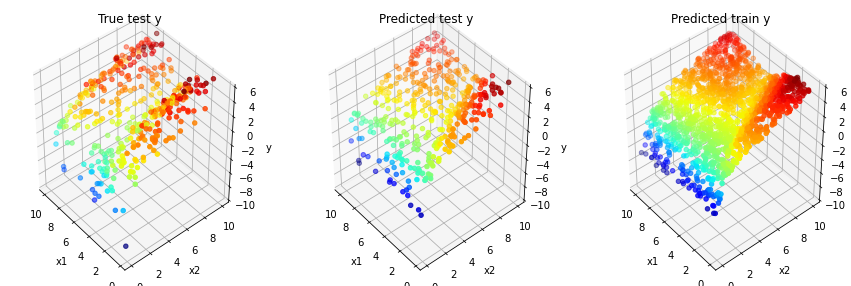

3000 tensor(1.6196, grad_fn=<MseLossBackward>)


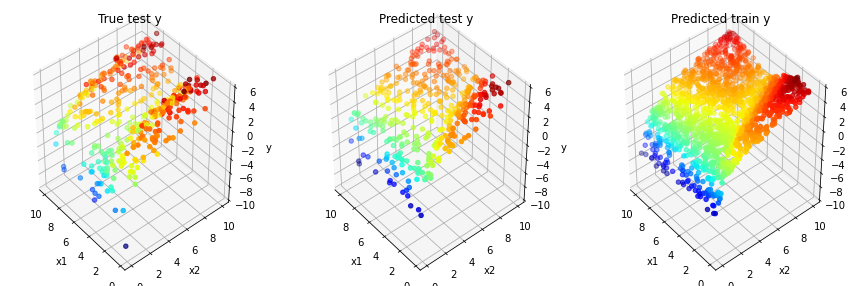

3200 tensor(1.5730, grad_fn=<MseLossBackward>)


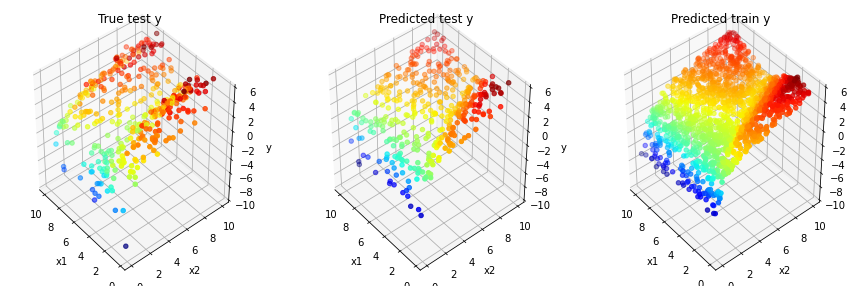

3400 tensor(1.5179, grad_fn=<MseLossBackward>)


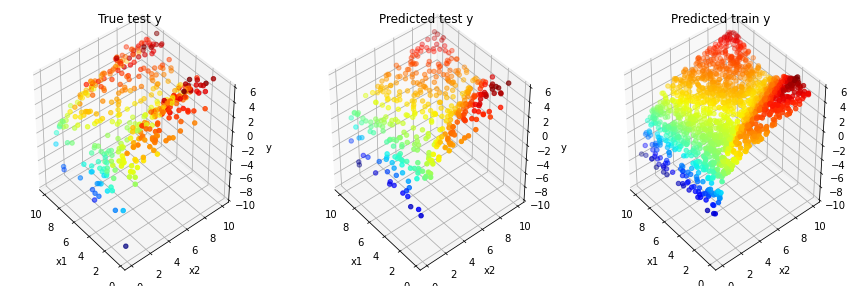

3600 tensor(1.4640, grad_fn=<MseLossBackward>)


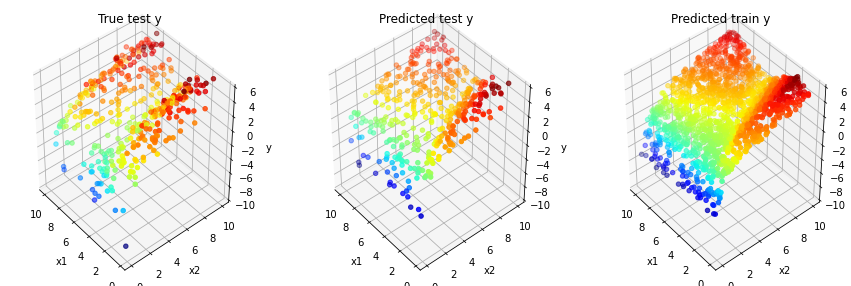

3800 tensor(1.4177, grad_fn=<MseLossBackward>)


In [5]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
#모델 확인할때 사용하는 코드
'''
model = LinearModel()
print(model.linear.weight)
print(model.linear.bias)
'''

model = MLPModel() # Model 생성
#복잡해보이지만 간단히 모델 내에 학습이 진행될 파라미터 수를 카운팅하는 코드
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) 

#Optimizer
lr = 0.005  #Learning Rate
optimizer = optim.SGD(model.parameters(), lr=lr)  #Optimizer 생성

#매 학습 단계에서의 epoch값,loss 값을 저장할 리스트
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []

epoch = 4000  #학습 횟수(epoch)
for i in range(epoch):
    
#train
#모델은 매 Iteration 때마다 Train Set에 의해 학습, 동시에 Validation Set을 넣고 Loss를 비교
    model.train()  #model을 train으로 세팅->향후 모델을 평가할 때는 eval()로 변경
    optimizer.zero_grad() #optimizer에 남아있을 수도 있는 잔여 gradient 0으로 다 초기화
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원 체크하는 print문
    
    loss = reg_loss(pred_y.squeeze(), true_y)
    loss.backward()  #backward()로 gradient 구하기(사용한 각 파라미터에 대한 loss의 편미분을 계산)
    optimizer.step()  #step()로 gradient 바탕의 파라미터 업데이트 진행
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())  

#Valid
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    
#Evaluate
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포 print
        
#MAE 계산
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)       
        fig = plt.figure(figsize=(15,5))
        
#True Y Scatter
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')       
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

#Predicted Y Scatter
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

#Visualizaing with High Resolution
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()        
        plt.show()
        print(i, loss)

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

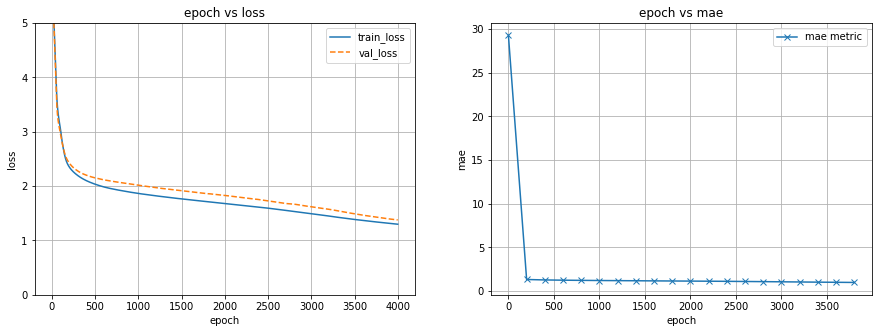

In [6]:
fig = plt.figure(figsize=(15,5))

#Loss Fluctuation(loss 변동사항 그리기)
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

#Metric Fluctuation(MAE 변동사항 그리기)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')
plt.show()